In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from scipy.stats import skew, kurtosis
from scipy.signal import welch

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import clone
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

warnings.filterwarnings("ignore")


In [2]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_rows", 500)

In [ ]:
df = pd.read_pickle("add_file_path")
df

,ecg_id,patient_id,recording_date,age,sex,height,weight,heart_axis,ecg_signals,CD,HYP,MI,NORM,STTC,diagnostic_superclass,strat_fold
1,2,13243.0,1984-11-14 12:55:37,19.0,0,171.116262,70.000000,NO_DATA,"[[-0.015, 0.12, 0.135, -0.053, -0.075, 0.127, ...",0,0,0,1,0,[NORM],2
2,3,20372.0,1984-11-15 12:49:10,37.0,1,167.893889,69.000000,NO_DATA,"[[-0.035, -0.07, -0.035, 0.053, 0.0, -0.052, 0...",0,0,0,1,0,[NORM],5
6,7,16193.0,1984-11-28 13:32:22,54.0,0,182.063572,83.000000,LAD,"[[-0.09, -0.02, 0.07, 0.055, -0.08, 0.025, 0.0...",0,0,0,1,0,[NORM],7
9,10,9456.0,1984-12-12 14:12:46,22.0,1,155.647387,56.000000,NO_DATA,"[[-0.065, -0.12, -0.055, 0.093, -0.005, -0.087...",0,0,0,1,0,[NORM],9
11,12,11031.0,1984-12-21 08:02:26,43.0,1,162.576546,44.000000,NO_DATA,"[[0.265, 0.35, 0.085, -0.308, 0.09, 0.217, -0....",0,0,0,1,0,[NORM],8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21791,21830,10520.0,2001-05-28 07:53:21,86.0,0,166.941744,86.053314,MID,"[[-0.09, 0.05, 0.14, 0.02, -0.115, 0.095, -0.1...",0,0,0,1,0,[NORM],1
21792,21831,11905.0,2001-05-28 12:49:25,55.0,1,162.030533,74.251460,MID,"[[-0.06, -0.065, -0.005, 0.063, -0.027, -0.035...",0,0,0,1,0,[NORM],9
21793,21832,7954.0,2001-05-30 14:14:25,63.0,0,181.949989,79.369158,LAD,"[[-0.07, -0.03, 0.04, 0.05, -0.055, 0.005, 0.1...",1,0,0,0,0,[CD],7
21795,21834,20703.0,2001-06-05 11:33:39,98.0,0,177.994169,93.194087,MID,"[[-0.035, 0.005, 0.04, 0.015, -0.038, 0.022, 0...",0,0,0,1,0,[NORM],4


In [4]:
df.shape

(12637, 16)

# Доработаем датасет


Посмотрим на распределение таргетных классов "CD", "HYP", "MI", "NORM", "STTC" основных заболеваний и нормы :

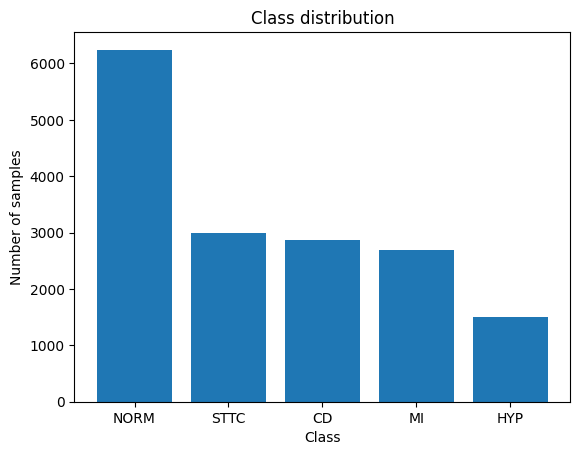

In [5]:
target_cols = ["CD", "HYP", "MI", "NORM", "STTC"]
class_counts = df[target_cols].sum().sort_values(ascending=False)
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class distribution")
plt.show()

Видно, что классы болезни/норма несбалансированы.\
Также у пациентов может одновременно могут быть указаны несколько видов диагнозов "CD", "HYP", "MI","STTC" - их комбинации. Выведем все уникальные значения в столбце diagnostic_superclass

In [6]:
value_diagnostic_superclass = df['diagnostic_superclass'].value_counts()
percent_diagnoz = df['diagnostic_superclass'].value_counts(normalize=True) * 100
result = pd.DataFrame({
    'Количество': value_diagnostic_superclass,
    'Процент': percent_diagnoz.round(1)
})
print(result)

                       Количество  Процент
diagnostic_superclass                     
[NORM]                       5917     46.8
[STTC]                       1391     11.0
[MI]                         1060      8.4
[CD]                         1007      8.0
[CD, MI]                      692      5.5
[STTC, HYP]                   384      3.0
[HYP]                         354      2.8
[STTC, MI]                    334      2.6
[CD, NORM]                    295      2.3
[CD, STTC]                    273      2.2
[STTC, MI, HYP]               213      1.7
[CD, HYP]                     164      1.3
[MI, HYP]                      94      0.7
[CD, MI, STTC]                 79      0.6
[CD, STTC, HYP]                75      0.6
[CD, STTC, MI, HYP]            72      0.6
[CD, STTC, MI]                 58      0.5
[CD, MI, HYP]                  56      0.4
[STTC, CD, HYP]                42      0.3
[STTC, CD, MI, HYP]            30      0.2
[STTC, NORM]                   24      0.2
[CD, HYP, S

Удалим строки, где класс нормы(Norm) сочитается с другими классами. Так как c медицинской точки зрения такого быть не должно, плюс таких строк мало и скорее всего это ошибки.

In [7]:
mask_bad = ((df["NORM"] == 1) &
           ((df["CD"] == 1) |
            (df["HYP"] == 1) |
            (df["MI"]  == 1) |
           (df["STTC"] == 1)))

df = df.loc[~mask_bad].reset_index(drop=True)

In [8]:
df.shape

(12311, 16)

Из всех возможных комбинаций диагнозов для одного объекта(порядок диагнозов не важен) соберем уникальные классы

In [9]:
mapping = {
    "CD": "C",
    "HYP": "H",
    "MI": "M",
    "STTC": "S",}

def make_combo_class(row):
    letters = "".join(
        mapping[col] 
        for col in ["MI", "HYP", "CD", "STTC"] 
        if row[col] == 1
    )
    if letters == "":
        return "N"   
    return letters

In [10]:
df["combo_class"] = df.apply(make_combo_class, axis=1)

Проверим, что получилось

In [11]:
df.combo_class.nunique()

16

In [12]:
df.combo_class.value_counts()

combo_class
N       5917
S       1391
M       1060
C       1007
MC       692
HS       384
H        354
MS       334
CS       273
MHS      213
HC       164
MCS      137
HCS      128
MHCS     107
MH        94
MHC       56
Name: count, dtype: int64

Посмотрим на распределение всех классов после обработки таргетной переменной 

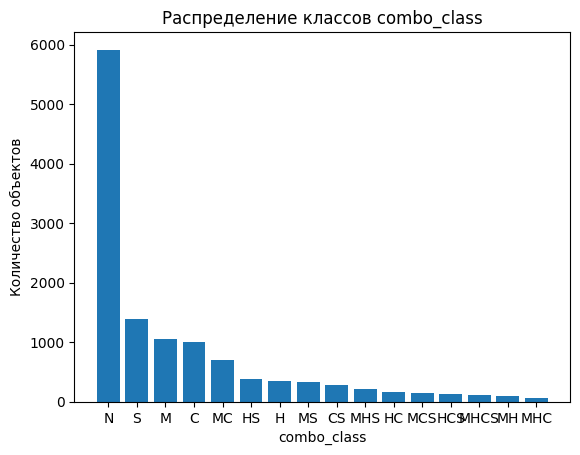

In [13]:
class_counts = df["combo_class"].value_counts().sort_values(ascending=False)
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("combo_class")
plt.ylabel("Количество объектов")
plt.title("Распределение классов combo_class")
plt.show()

С учетом комплексных классов (из сочетаний диагнозов) дисбаланс стал ещё более выраженным: почти половина наблюдений относится к классу N, тогда как ряд комбинаций встречается менее чем в 1 % случаев. Тем не менее, попробуем сделать мультиклассовую классификацию из всех 16 классов. Постараемся компенсировать дисбаланс на этапе обучения модели (за счёт настроек алгоритма).

Добавим колонку с числовым кодом для каждого комбо класса (закодируем)

In [14]:
df["combo_idx"], combo_uniques = pd.factorize(df["combo_class"])
y = df["combo_idx"].values

In [15]:
code_map = (
    df[["combo_idx", "combo_class"]]
    .drop_duplicates()
    .sort_values("combo_idx")
    .reset_index(drop=True)
)
print(code_map)

    combo_idx combo_class
0           0           N
1           1           S
2           2          MS
3           3           C
4           4          MC
5           5          CS
6           6           M
7           7           H
8           8         MHS
9           9        MHCS
10         10          HC
11         11         MCS
12         12          HS
13         13         HCS
14         14          MH
15         15         MHC


**Описание получившихся классов**

**0 - N**   - Normal ECG

**1 - S**   - ST/T Change

**2 - MS**  - Myocardial Infarction + ST/T Change

**3 - C**   - Conduction Disturbance

**4 - MC**  - Myocardial Infarction + Conduction Disturbance

**5 - CS**  - Conduction Disturbance + ST/T Change

**6 - M**   - Myocardial Infarction

**7 - H**   - Hypertrophy

**8 - MHS** - Myocardial Infarction + Hypertrophy + ST/T Change

**9 - MHCS** - Myocardial Infarction + Hypertrophy + Conduction Disturbance + ST/T Change

**10 - HC**  - Hypertrophy + Conduction Disturbance

**11 - MCS** - Myocardial Infarction + Conduction Disturbance + ST/T Change

**12 - HS**  - Hypertrophy + ST/T Change

**13 - HCS** - Hypertrophy + Conduction Disturbance + ST/T Change

**14 - MH**  - Myocardial Infarction + Hypertrophy

**15 - MHC** - Myocardial Infarction + Hypertrophy + Conduction Disturbance


Обработаем столбец heart_axis

Посмотрим на уникальные значения в этом столбце

In [16]:
heart_axis_unique = df['heart_axis'].nunique()
print(f'Количество уникальных значений столбца heart_axis: {heart_axis_unique}')

Количество уникальных значений столбца heart_axis: 9


In [17]:
value_heart_axis = df['heart_axis'].value_counts()
print(f'Уникальные значения с их частотой:\n {value_heart_axis}')

Уникальные значения с их частотой:
 heart_axis
NO_DATA    6705
MID        2987
LAD        1827
ALAD        530
RAD          92
AXL          89
AXR          42
ARAD         36
SAG           3
Name: count, dtype: int64


Значения MID и NO_DATA - говорит о нормальном отклонении элекрической оси. Если брать в расчет распределние болен/ не болен, то большая часть с диагнозом NORM, что и подтвеждают данные в столбце heart_axis.\
Остальные значения связаны уже с отклонением от нормы (напрмер, LAD - это отклонение влево)

Проверим также на пропуски

In [18]:
missing_heart_axis = df['heart_axis'].isnull().sum()
print(f'Количество пропусков в столбце heart_axis: {missing_heart_axis}')

Количество пропусков в столбце heart_axis: 0


Закодируем столбец heart_axis методом One Hot Encoding

In [19]:
df = pd.get_dummies(df, columns=["heart_axis"], prefix="heart_axis")

In [20]:
df.head(3)

,ecg_id,patient_id,recording_date,age,sex,height,weight,ecg_signals,CD,HYP,MI,NORM,STTC,diagnostic_superclass,strat_fold,combo_class,combo_idx,heart_axis_ALAD,heart_axis_ARAD,heart_axis_AXL,heart_axis_AXR,heart_axis_LAD,heart_axis_MID,heart_axis_NO_DATA,heart_axis_RAD,heart_axis_SAG
0,2,13243.0,1984-11-14 12:55:37,19.0,0,171.116262,70.0,"[[-0.015, 0.12, 0.135, -0.053, -0.075, 0.127, ...",0,0,0,1,0,[NORM],2,N,0,False,False,False,False,False,False,True,False,False
1,3,20372.0,1984-11-15 12:49:10,37.0,1,167.893889,69.0,"[[-0.035, -0.07, -0.035, 0.053, 0.0, -0.052, 0...",0,0,0,1,0,[NORM],5,N,0,False,False,False,False,False,False,True,False,False
2,7,16193.0,1984-11-28 13:32:22,54.0,0,182.063572,83.0,"[[-0.09, -0.02, 0.07, 0.055, -0.08, 0.025, 0.0...",0,0,0,1,0,[NORM],7,N,0,False,False,False,False,True,False,False,False,False


Проверим наличие дубликатов в столбце ecg_id

In [21]:
dupli_ecg_id = df['ecg_id'].duplicated().sum()
print(f'Наличие дублей по id ЭКГ (сумма таких сигналов): {dupli_ecg_id}')

Наличие дублей по id ЭКГ (сумма таких сигналов): 0


**Обраблтка ЭКГ сигналов**
1. ЭКГ сигналы находятся в формате array.
2. У каждого пациента есть сигналы по 12 отведениям, каждое отдельное отведение представлено временным рядом из 5000 точек измерений
3. Для генерирования признаков использовался статистический метод, с параметрами как mean, max, min, median, std, разница между max и min, а также  среднеквадратичное значение сигнала
4. Для создания медицинских признаков по ЭКГ сигналов используем библиотеки из экосистемы SciPy для научных вычислений


In [22]:
#Функция для извлечения статистических признаков из массива ЭКГ была сгенерирована с помощью AI
def extract_ecg_features(ecg):
    features = {}
    num_leads = ecg.shape[1]
    
    for lead_idx in range(num_leads):
        lead = ecg[:, lead_idx]
        prefix = f"lead{lead_idx+1}"

        #Базовые статистики
        features[f"{prefix}_mean"] = np.mean(lead)
        features[f"{prefix}_median"] = np.median(lead)
        features[f"{prefix}_std"] = np.std(lead)
        features[f"{prefix}_min"] = np.min(lead)
        features[f"{prefix}_max"] = np.max(lead)
        features[f"{prefix}_range"] = np.max(lead) - np.min(lead)
        features[f"{prefix}_rms"] = np.sqrt(np.mean(lead**2))

        #Форма сигнала
        features[f"{prefix}_skew"] = skew(lead)
        features[f"{prefix}_kurt"] = kurtosis(lead)

        #Энергетические признаки
        features[f"{prefix}_energy"] = np.sum(lead**2)
        features[f"{prefix}_norm_energy"] = np.sum(lead**2) / len(lead)

        #Частотные признаки на основе Welch
        freqs, psd = welch(lead, fs=500)
        features[f"{prefix}_dom_freq"] = freqs[np.argmax(psd)]
        features[f"{prefix}_spec_entropy"] = -np.sum((psd/np.sum(psd)) * np.log(psd/np.sum(psd) + 1e-12))

        #LF/HF диапазоны
        lf_band = (freqs >= 0.04) & (freqs <= 0.15)
        hf_band = (freqs >= 0.15) & (freqs <= 0.40)

        lf_energy = np.sum(psd[lf_band])
        hf_energy = np.sum(psd[hf_band])

        features[f"{prefix}_lf_energy"] = lf_energy
        features[f"{prefix}_hf_energy"] = hf_energy
        features[f"{prefix}_lf_hf_ratio"] = lf_energy / (hf_energy + 1e-6)

    return features

#Сгенерируем признаки для всех пациентов в датасете
feature_rows = []

for idx, row in df.iterrows():
    ecg = row["ecg_signals"]
    feats = extract_ecg_features(ecg)
    feature_rows.append(feats)

ecg_features_df = pd.DataFrame(feature_rows)

print("Размер таблицы признаков:", ecg_features_df.shape)

#Сформируем финальный датафрейм: удалим колонку ecg_signals и добавим новые статистические признаки
df_final = pd.concat(
    [
        df.drop(columns=["ecg_signals"]).reset_index(drop=True),
        ecg_features_df.reset_index(drop=True)
    ],
    axis=1
)

print("Финальный датасет для обучения имеет размер:", df_final.shape)

Размер таблицы признаков: (12311, 192)
Финальный датасет для обучения имеет размер: (12311, 217)


*Описание созданных признаков*

1. Базовые статистические признаки (характеризуют форму и уровень сигнала)
Для каждого отведения рассчитываются:
 • среднее значение (mean)
 • медиана (median)
 • стандартное отклонение (std)
 • минимальное (min) и максимальное (max) значения
 • размах (range)
 • среднеквадратичное значение (RMS)

2. Признаки формы распределения
 • асимметрия (skew)
 • эксцесс (kurtosis)

3. Энергетические признаки
 • суммарная энергия (energy)
 • нормированная энергия (norm_energy)

4. Частотные признаки (на основе спектральной плотности Welch)
 • dominant frequency — частота, на которой сигнал имеет максимум энергии;
 • spectral entropy — спектральная энтропия, отражает степень хаотичности спектра.

5. LF/HF показатели
Рассчитываются мощности в диапазонах:
 • LF (0.04–0.15 Гц)
 • HF (0.15–0.40 Гц)
 • и их отношение LF/HF ratio.


Разобъем датасет на трэйн тест. Создатели датасета рекомендуют делать это по колонке strat_fold. 1-8 train, 9-10 test

In [23]:
df_final["strat_fold"] = df_final["strat_fold"].astype(int)

train_mask = df_final["strat_fold"].between(1, 8)
test_mask  = df_final["strat_fold"].between(9, 10)

df_train = df_final[train_mask].copy()
df_test  = df_final[test_mask].copy()

n_train = len(df_train)
n_test = len(df_test)
n_total = n_train + n_test

print(f" Размер TRAIN: {df_train.shape};\n Размер TEST: {df_test.shape}")
print(f"train :  {(n_train / n_total):.2f}")
print(f"test :   {(n_test / n_total):.2f}")

 Размер TRAIN: (9127, 217);
 Размер TEST: (3184, 217)
train :  0.74
test :   0.26


Проверим, нет ли пересекающихся пациентов между трэйн и тест по столбцу patient_id, чтобы избежать data leak

In [24]:
train_patients = set(df_train["patient_id"])
test_patients  = set(df_test["patient_id"])

cross_of_train_test = train_patients & test_patients

print(f'Есть ли пересечение множеств TRAIN & TEST : {len(cross_of_train_test)}')


Есть ли пересечение множеств TRAIN & TEST : 0


Поделим датасет 

In [25]:
base_feats = ["age", "sex", "height", "weight"]

heart_feats = [c for c in df_final.columns if c.startswith("heart_axis_")]

ecg_feats = [c for c in df_final.columns if c.startswith("lead") or c in ["rr_mean", "rr_std", "hr_mean"]]

feature_cols = base_feats + heart_feats + ecg_feats

len(feature_cols)

205

In [26]:
df_train.head()

,ecg_id,patient_id,recording_date,age,sex,height,weight,CD,HYP,MI,NORM,STTC,diagnostic_superclass,strat_fold,combo_class,combo_idx,heart_axis_ALAD,heart_axis_ARAD,heart_axis_AXL,heart_axis_AXR,heart_axis_LAD,heart_axis_MID,heart_axis_NO_DATA,heart_axis_RAD,heart_axis_SAG,lead1_mean,lead1_median,lead1_std,lead1_min,lead1_max,lead1_range,lead1_rms,lead1_skew,lead1_kurt,lead1_energy,lead1_norm_energy,lead1_dom_freq,lead1_spec_entropy,lead1_lf_energy,lead1_hf_energy,lead1_lf_hf_ratio,lead2_mean,lead2_median,lead2_std,lead2_min,lead2_max,lead2_range,lead2_rms,lead2_skew,lead2_kurt,lead2_energy,lead2_norm_energy,lead2_dom_freq,lead2_spec_entropy,lead2_lf_energy,lead2_hf_energy,lead2_lf_hf_ratio,lead3_mean,lead3_median,lead3_std,lead3_min,lead3_max,lead3_range,lead3_rms,lead3_skew,lead3_kurt,lead3_energy,lead3_norm_energy,lead3_dom_freq,lead3_spec_entropy,lead3_lf_energy,lead3_hf_energy,lead3_lf_hf_ratio,lead4_mean,lead4_median,lead4_std,lead4_min,lead4_max,lead4_range,lead4_rms,lead4_skew,lead4_kurt,lead4_energy,lead4_norm_energy,lead4_dom_freq,lead4_spec_entropy,lead4_lf_energy,lead4_hf_energy,lead4_lf_hf_ratio,lead5_mean,lead5_median,lead5_std,lead5_min,lead5_max,lead5_range,lead5_rms,lead5_skew,lead5_kurt,lead5_energy,lead5_norm_energy,lead5_dom_freq,lead5_spec_entropy,lead5_lf_energy,lead5_hf_energy,lead5_lf_hf_ratio,lead6_mean,lead6_median,lead6_std,lead6_min,lead6_max,lead6_range,lead6_rms,lead6_skew,lead6_kurt,lead6_energy,lead6_norm_energy,lead6_dom_freq,lead6_spec_entropy,lead6_lf_energy,lead6_hf_energy,lead6_lf_hf_ratio,lead7_mean,lead7_median,lead7_std,lead7_min,lead7_max,lead7_range,lead7_rms,lead7_skew,lead7_kurt,lead7_energy,lead7_norm_energy,lead7_dom_freq,lead7_spec_entropy,lead7_lf_energy,lead7_hf_energy,lead7_lf_hf_ratio,lead8_mean,lead8_median,lead8_std,lead8_min,lead8_max,lead8_range,lead8_rms,lead8_skew,lead8_kurt,lead8_energy,lead8_norm_energy,lead8_dom_freq,lead8_spec_entropy,lead8_lf_energy,lead8_hf_energy,lead8_lf_hf_ratio,lead9_mean,lead9_median,lead9_std,lead9_min,lead9_max,lead9_range,lead9_rms,lead9_skew,lead9_kurt,lead9_energy,lead9_norm_energy,lead9_dom_freq,lead9_spec_entropy,lead9_lf_energy,lead9_hf_energy,lead9_lf_hf_ratio,lead10_mean,lead10_median,lead10_std,lead10_min,lead10_max,lead10_range,lead10_rms,lead10_skew,lead10_kurt,lead10_energy,lead10_norm_energy,lead10_dom_freq,lead10_spec_entropy,lead10_lf_energy,lead10_hf_energy,lead10_lf_hf_ratio,lead11_mean,lead11_median,lead11_std,lead11_min,lead11_max,lead11_range,lead11_rms,lead11_skew,lead11_kurt,lead11_energy,lead11_norm_energy,lead11_dom_freq,lead11_spec_entropy,lead11_lf_energy,lead11_hf_energy,lead11_lf_hf_ratio,lead12_mean,lead12_median,lead12_std,lead12_min,lead12_max,lead12_range,lead12_rms,lead12_skew,lead12_kurt,lead12_energy,lead12_norm_energy,lead12_dom_freq,lead12_spec_entropy,lead12_lf_energy,lead12_hf_energy,lead12_lf_hf_ratio
0,2,13243.0,1984-11-14 12:55:37,19.0,0,171.116262,70.0,0,0,0,1,0,[NORM],2,N,0,False,False,False,False,False,False,True,False,False,-0.003573,-0.044,0.130397,-0.419,0.686,1.105,0.130446,1.991794,4.772568,85.081125,0.017016,1.953125,2.415966,0.0,0.0,0.0,-0.003432,-0.015,0.243888,-0.420,1.625,2.045,0.243912,1.377724,5.181144,297.466160,0.059493,1.953125,2.629292,0.0,0.0,0.0,0.000147,0.019,0.189780,-0.383,0.995,1.378,0.189780,0.397424,0.905339,180.082834,0.036017,1.953125,2.476070,0.0,0.0,0.0,0.003506,0.023,0.171111,-1.150,0.327,1.477,0.171147,-1.885048,6.394347,146.456583,0.029291,1.953125,2.578604,0.0,0.0,0.0,-0.001857,-0.0080,0.107985,-0.443,0.317,0.760,0.108001,0.274985,0.033222,58.321382,0.011664,1.953125,2.004609,0.0,0.0,0.0,-0.001662,0.005,0.208359,-0.375,1.287,1.662,0.208366,0.908756,3.324271,217.080925,0.043416,1.953125,2.629579,0.0,0.0,0.0,0.004484,0.030,0.219239,-1.918,0.340,2.258,0.219285,-4.560359,27.186936,240.428483,0.048086,3.90625,2.425722,0.0,0.0,0.0,0.012612,0.0185,0.422281,-3.335,0.966,4.301,0.422470,-4.155571,25.002454,892.402444,0.178480,1.953125,2.343320,0.0,0.0,0.0,0.012074,-0.015,0.3574

In [27]:
X_train = df_train[feature_cols]
y_train = df_train["combo_idx"]


X_test  = df_test[feature_cols]
y_test  = df_test["combo_idx"]



In [28]:
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(9127, 205) (9127,)
(3184, 205) (3184,)


In [29]:
diag_cols = ["CD", "HYP", "MI", "NORM", "STTC"]

In [30]:
X_train

,age,sex,height,weight,heart_axis_ALAD,heart_axis_ARAD,heart_axis_AXL,heart_axis_AXR,heart_axis_LAD,heart_axis_MID,heart_axis_NO_DATA,heart_axis_RAD,heart_axis_SAG,lead1_mean,lead1_median,lead1_std,lead1_min,lead1_max,lead1_range,lead1_rms,lead1_skew,lead1_kurt,lead1_energy,lead1_norm_energy,lead1_dom_freq,lead1_spec_entropy,lead1_lf_energy,lead1_hf_energy,lead1_lf_hf_ratio,lead2_mean,lead2_median,lead2_std,lead2_min,lead2_max,lead2_range,lead2_rms,lead2_skew,lead2_kurt,lead2_energy,lead2_norm_energy,lead2_dom_freq,lead2_spec_entropy,lead2_lf_energy,lead2_hf_energy,lead2_lf_hf_ratio,lead3_mean,lead3_median,lead3_std,lead3_min,lead3_max,lead3_range,lead3_rms,lead3_skew,lead3_kurt,lead3_energy,lead3_norm_energy,lead3_dom_freq,lead3_spec_entropy,lead3_lf_energy,lead3_hf_energy,lead3_lf_hf_ratio,lead4_mean,lead4_median,lead4_std,lead4_min,lead4_max,lead4_range,lead4_rms,lead4_skew,lead4_kurt,lead4_energy,lead4_norm_energy,lead4_dom_freq,lead4_spec_entropy,lead4_lf_energy,lead4_hf_energy,lead4_lf_hf_ratio,lead5_mean,lead5_median,lead5_std,lead5_min,lead5_max,lead5_range,lead5_rms,lead5_skew,lead5_kurt,lead5_energy,lead5_norm_energy,lead5_dom_freq,lead5_spec_entropy,lead5_lf_energy,lead5_hf_energy,lead5_lf_hf_ratio,lead6_mean,lead6_median,lead6_std,lead6_min,lead6_max,lead6_range,lead6_rms,lead6_skew,lead6_kurt,lead6_energy,lead6_norm_energy,lead6_dom_freq,lead6_spec_entropy,lead6_lf_energy,lead6_hf_energy,lead6_lf_hf_ratio,lead7_mean,lead7_median,lead7_std,lead7_min,lead7_max,lead7_range,lead7_rms,lead7_skew,lead7_kurt,lead7_energy,lead7_norm_energy,lead7_dom_freq,lead7_spec_entropy,lead7_lf_energy,lead7_hf_energy,lead7_lf_hf_ratio,lead8_mean,lead8_median,lead8_std,lead8_min,lead8_max,lead8_range,lead8_rms,lead8_skew,lead8_kurt,lead8_energy,lead8_norm_energy,lead8_dom_freq,lead8_spec_entropy,lead8_lf_energy,lead8_hf_energy,lead8_lf_hf_ratio,lead9_mean,lead9_median,lead9_std,lead9_min,lead9_max,lead9_range,lead9_rms,lead9_skew,lead9_kurt,lead9_energy,lead9_norm_energy,lead9_dom_freq,lead9_spec_entropy,lead9_lf_energy,lead9_hf_energy,lead9_lf_hf_ratio,lead10_mean,lead10_median,lead10_std,lead10_min,lead10_max,lead10_range,lead10_rms,lead10_skew,lead10_kurt,lead10_energy,lead10_norm_energy,lead10_dom_freq,lead10_spec_entropy,lead10_lf_energy,lead10_hf_energy,lead10_lf_hf_ratio,lead11_mean,lead11_median,lead11_std,lead11_min,lead11_max,lead11_range,lead11_rms,lead11_skew,lead11_kurt,lead11_energy,lead11_norm_energy,lead11_dom_freq,lead11_spec_entropy,lead11_lf_energy,lead11_hf_energy,lead11_lf_hf_ratio,lead12_mean,lead12_median,lead12_std,lead12_min,lead12_max,lead12_range,lead12_rms,lead12_skew,lead12_kurt,lead12_energy,lead12_norm_energy,lead12_dom_freq,lead12_spec_entropy,lead12_lf_energy,lead12_hf_energy,lead12_lf_hf_ratio
0,19.0,0,171.116262,70.000000,False,False,False,False,False,False,True,False,False,-0.003573,-0.044,0.130397,-0.419,0.686,1.105,0.130446,1.991794,4.772568,85.081125,0.017016,1.953125,2.415966,0.0,0.0,0.0,-0.003432,-0.015,0.243888,-0.420,1.625,2.045,0.243912,1.377724,5.181144,297.466160,0.059493,1.953125,2.629292,0.0,0.0,0.0,0.000147,0.019,0.189780,-0.383,0.995,1.378,0.189780,0.397424,0.905339,180.082834,0.036017,1.953125,2.476070,0.0,0.0,0.0,0.003506,0.023,0.171111,-1.150,0.327,1.477,0.171147,-1.885048,6.394347,146.456583,0.029291,1.953125,2.578604,0.0,0.0,0.0,-0.001857,-0.0080,0.107985,-0.443,0.317,0.760,0.108001,0.274985,0.033222,58.321382,0.011664,1.953125,2.004609,0.0,0.0,0.0,-0.001662,0.005,0.208359,-0.375,1.287,1.662,0.208366,0.908756,3.324271,217.080925,0.043416,1.953125,2.629579,0.0,0.0,0.0,0.004484,0.030,0.219239,-1.918,0.340,2.258,0.219285,-4.560359,27.186936,240.428483,0.048086,3.906250,2.425722,0.0,0.0,0.0,0.012612,0.0185,0.422281,-3.335,0.966,4.301,0.422470,-4.155571,25.002454,892.402444,0.178480,1.953125,2.343320,0.0,0.0,0.0,0.012074,-0.015,0.357462,-2.327,1.016,3.343,0.357666,-2.305492,13.818850,639.624532,0.127925,1.953125,2.217202,0.0,0.0,0.0,0.000951,-0.065,0.274955,-1.115,2.356,3.471,0.274957,3

In [31]:
y_train.head(20)

0     0
1     0
2     0
4     0
5     0
6     0
7     0
8     1
9     0
10    0
12    0
13    0
14    0
15    0
16    0
20    0
21    0
22    0
23    0
24    3
Name: combo_idx, dtype: int64

In [32]:
y_train.head(100)

0       0
1       0
2       0
4       0
5       0
6       0
7       0
8       1
9       0
10      0
12      0
13      0
14      0
15      0
16      0
20      0
21      0
22      0
23      0
24      3
25      0
26      1
27      0
29      0
30      0
32      0
34      0
35      0
36      0
37      0
38      0
39      0
40      4
41      0
43      0
44      0
45      0
46      0
47      0
49      0
50      0
51      0
52      0
53      5
54      4
55      0
56      0
57      0
58      0
59      0
61      0
62      0
63      0
65      0
66      0
67      0
69      6
72      0
73      7
74      8
75      0
76      1
77      0
81      0
83      0
84      0
86      6
88      0
89      0
91      1
94      0
95      6
97      4
98      0
99      0
101     3
102    10
103     3
105     0
106     0
112     0
113     0
115     5
116     0
117     0
121     3
122     0
123    10
125     0
126     0
127     3
128     0
130     0
131     0
132     0
136     0
137     0
138     0
139     0
140     0


# Мультиклассификация

In [33]:
models = {
    "LogisticRegression_OvR": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", OneVsRestClassifier(
            LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                random_state=42
            )
        ))
    ]),
    "LinearSVC_OvR": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", OneVsRestClassifier(
            LinearSVC(
                class_weight="balanced",
                random_state=42
            )
        ))
    ]),
    "SGD_log_loss_OvR": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", OneVsRestClassifier(
            SGDClassifier(
                loss="log_loss",
                max_iter=2000,
                class_weight="balanced",
                random_state=42
            )
        ))
    ])
}

In [34]:
results = []

for name, model in models.items():
    print(f"Модель: {name}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    actual_labels = sorted(np.unique(np.concatenate([y_train, y_test, y_pred])))
    print(f"Количество классов: {len(actual_labels)}")

    accuracy = accuracy_score(y_test, y_pred)
    
    prec_micro = precision_score(y_test, y_pred, average="micro", zero_division=0)
    rec_micro = recall_score(y_test, y_pred, average="micro", zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    
    prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    
    prec_weighted = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec_weighted = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    print(f"Accuracy:           {accuracy:.3f}")
    print(f"F1-micro:           {f1_micro:.3f}")
    print(f"F1-macro:           {f1_macro:.3f}")
    print(f"F1-weighted:        {f1_weighted:.3f}")
    print(f"Precision-micro:    {prec_micro:.3f}")
    print(f"Recall-micro:       {rec_micro:.3f}")

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, 
                                labels=actual_labels,
                                zero_division=0,
                                digits=3))

    results.append({
        "model": name,
        "accuracy": accuracy,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "prec_micro": prec_micro,
        "rec_micro": rec_micro,
        "prec_macro": prec_macro,
        "rec_macro": rec_macro,
        "num_classes": len(actual_labels)
    })

results_df = pd.DataFrame(results)
print("ИТОГОВАЯ ТАБЛИЦА (сортировка по F1-macro)")
print(results_df.sort_values("f1_macro", ascending=False).round(4))

Модель: LogisticRegression_OvR
Количество классов: 16
Accuracy:           0.446
F1-micro:           0.446
F1-macro:           0.212
F1-weighted:        0.479
Precision-micro:    0.446
Recall-micro:       0.446

Classification report:
              precision    recall  f1-score   support

           0      0.841     0.703     0.766      1396
           1      0.420     0.349     0.381       370
           2      0.123     0.212     0.156        99
           3      0.396     0.246     0.304       272
           4      0.292     0.179     0.222       196
           5      0.089     0.215     0.126        65
           6      0.335     0.204     0.253       339
           7      0.253     0.380     0.304       100
           8      0.147     0.242     0.183        62
           9      0.103     0.269     0.149        26
          10      0.030     0.093     0.045        43
          11      0.048     0.171     0.075        35
          12      0.196     0.206     0.201       107
         

Все модели страдают от сильного дисбаланса классов: F1-macro (0.09-0.21) значительно ниже F1-weighted (0.24-0.48)

Модели хорошо предсказывают только крупные классы (0, 1)

Мелкие классы (9-15) почти не предсказываются (f1 < 0.13)

# One vs Rest подход

Поскольку дисбаланс комбенированных классов очень велик, попробуем упростить задачу до бинарной классификации. Будем считать класс 0 — NORM (отсутствие патологий), а все случаи с любыми заболеваниями (любой не-N класс) объединим в класс 1 - PATHOLOGY.

In [35]:
y_train_bin = (y_train != 0).astype(int)
y_test_bin  = (y_test  != 0).astype(int)

In [36]:
y_train_bin.value_counts()

combo_idx
1    4606
0    4521
Name: count, dtype: int64

In [37]:
y_test_bin.value_counts()

combo_idx
1    1788
0    1396
Name: count, dtype: int64

In [38]:
ovr_results = []

for name, base_model in models.items():
    print(f"\nМодель: OVR_{name}")
    
    model = clone(base_model)
    
    ovr_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", OneVsRestClassifier(model.named_steps['clf']))
    ])

    ovr_pipeline.fit(X_train, y_train_bin) 
    y_pred = ovr_pipeline.predict(X_test)    
    
    actual_labels = sorted(np.unique(np.concatenate([y_train_bin, y_test_bin, y_pred])))
    print(f"Количество классов: {len(actual_labels)}")

    accuracy = accuracy_score(y_test_bin, y_pred)  
    
    prec_micro = precision_score(y_test_bin, y_pred, average="micro", zero_division=0)
    rec_micro = recall_score(y_test_bin, y_pred, average="micro", zero_division=0)
    f1_micro = f1_score(y_test_bin, y_pred, average="micro", zero_division=0)
    
    prec_macro = precision_score(y_test_bin, y_pred, average="macro", zero_division=0)
    rec_macro = recall_score(y_test_bin, y_pred, average="macro", zero_division=0)
    f1_macro = f1_score(y_test_bin, y_pred, average="macro", zero_division=0)
    
    prec_weighted = precision_score(y_test_bin, y_pred, average="weighted", zero_division=0)
    rec_weighted = recall_score(y_test_bin, y_pred, average="weighted", zero_division=0)
    f1_weighted = f1_score(y_test_bin, y_pred, average="weighted", zero_division=0)

    print(f"Accuracy:           {accuracy:.3f}")
    print(f"F1-micro:           {f1_micro:.3f}")
    print(f"F1-macro:           {f1_macro:.3f}")
    print(f"F1-weighted:        {f1_weighted:.3f}")
    print(f"Precision-micro:    {prec_micro:.3f}")
    print(f"Recall-micro:       {rec_micro:.3f}")

    print("\nClassification report:")
    print(classification_report(y_test_bin, y_pred, 
                                labels=actual_labels,
                                target_names=['NORM', 'PATHOLOGY'],
                                zero_division=0,
                                digits=3))

    ovr_results.append({
        "model": f"OVR_{name}",
        "accuracy": accuracy,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "prec_micro": prec_micro,
        "rec_micro": rec_micro,
        "prec_macro": prec_macro,
        "rec_macro": rec_macro,
        "num_classes": len(actual_labels)
    })

ovr_results_df = pd.DataFrame(ovr_results)
print("\nИТОГОВАЯ ТАБЛИЦА ONE-VS-REST (сортировка по F1-macro)")
print(ovr_results_df.sort_values("f1_macro", ascending=False).round(4))


Модель: OVR_LogisticRegression_OvR
Количество классов: 2
Accuracy:           0.808
F1-micro:           0.808
F1-macro:           0.808
F1-weighted:        0.809
Precision-micro:    0.808
Recall-micro:       0.808

Classification report:
              precision    recall  f1-score   support

        NORM      0.750     0.844     0.794      1396
   PATHOLOGY      0.865     0.781     0.821      1788

    accuracy                          0.808      3184
   macro avg      0.808     0.812     0.808      3184
weighted avg      0.815     0.808     0.809      3184


Модель: OVR_LinearSVC_OvR
Количество классов: 2
Accuracy:           0.803
F1-micro:           0.803
F1-macro:           0.802
F1-weighted:        0.804
Precision-micro:    0.803
Recall-micro:       0.803

Classification report:
              precision    recall  f1-score   support

        NORM      0.741     0.847     0.791      1396
   PATHOLOGY      0.866     0.768     0.814      1788

    accuracy                          0.80

**Вывод**:

При переходе к схеме «one vs rest» качество модели заметно улучшилось по сравнению с многоклассовой классификацией.На основе полученных результатов, лучшей моделью является OVR_LogisticRegression_OvR с наивысшими показателями по всем метрикам: accuracy 0.808, F1-macro 0.808 и F1-weighted 0.809. Модель OVR_LinearSVC_OvR показала сопоставимые результаты (accuracy 0.803), незначительно уступая логистической регрессии. Наименее эффективной оказалась модель OVR_SGD_log_loss_OvR с accuracy 0.767 В целом One vs Rest-подход даёт устойчивое и сбалансированное качество и выглядит более подходящим для данной задачи, чем классификация всех комбинаций диагнозов сразу.

Несмотря на хорошие метрики, бинарная постановка «NORM vs PATHOLOGY» не обеспечивает достаточной диагностической полноты: модель отвечает лишь на вопрос «есть заболевание или нет», но не позволяет различать конкретные диагнозы. Поэтому далее будем обучать отдельную бинарную модель для каждого диагноза (CD, HYP, MI, NORM, STTC и т.д.). Такой подход позволит оценивать риск каждой нозологии по отдельности и ближе к реальной клинической постановке задачи

# Бинарная классификация для каждого диагноза

In [39]:
target_cols = ["CD", "HYP", "MI", "NORM", "STTC"]

separate_results = []

for target in target_cols:
    y_train = df_train[target].astype(int).values
    y_test = df_test[target].astype(int).values
    
    print(f"\n{'='*60}")
    print(f"TARGET: {target}")
    print(f"{'='*60}")
    
 
    for name, base_model in models.items():
        print(f"\nМодель: {name}")
        
       
        model = clone(base_model)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        actual_labels = sorted(np.unique(np.concatenate([y_train, y_test, y_pred])))
        print(f"Количество классов: {len(actual_labels)}")

        accuracy = accuracy_score(y_test, y_pred)
        
        prec_micro = precision_score(y_test, y_pred, average="micro", zero_division=0)
        rec_micro = recall_score(y_test, y_pred, average="micro", zero_division=0)
        f1_micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
        
        prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
        rec_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
        f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
        
        prec_weighted = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        rec_weighted = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        print(f"Accuracy:           {accuracy:.3f}")
        print(f"F1-micro:           {f1_micro:.3f}")
        print(f"F1-macro:           {f1_macro:.3f}")
        print(f"F1-weighted:        {f1_weighted:.3f}")
        print(f"Precision-micro:    {prec_micro:.3f}")
        print(f"Recall-micro:       {rec_micro:.3f}")

        print("\nClassification report:")
        print(classification_report(y_test, y_pred, 
                                    labels=actual_labels,
                                    zero_division=0,
                                    digits=3))

        separate_results.append({
            "target": target,
            "model": name,
            "accuracy": accuracy,
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted,
            "prec_micro": prec_micro,
            "rec_micro": rec_micro,
            "prec_macro": prec_macro,
            "rec_macro": rec_macro,
            "num_classes": len(actual_labels)
        })

separate_results_df = pd.DataFrame(separate_results)
print("\nИТОГОВАЯ ТАБЛИЦА (отдельные модели для каждого таргета)")
print(separate_results_df.sort_values("f1_macro", ascending=False).round(4))


print("\n\nРЕЗУЛЬТАТЫ ПО КАЖДОМУ ТАРГЕТУ:")
for target in target_cols:
    print(f"\n{target}:")
    print(separate_results_df[separate_results_df['target'] == target].sort_values("f1_macro", ascending=False).round(4))


TARGET: CD

Модель: LogisticRegression_OvR
Количество классов: 2
Accuracy:           0.822
F1-micro:           0.822
F1-macro:           0.767
F1-weighted:        0.832
Precision-micro:    0.822
Recall-micro:       0.822

Classification report:
              precision    recall  f1-score   support

           0      0.934     0.832     0.880      2503
           1      0.560     0.786     0.654       681

    accuracy                          0.822      3184
   macro avg      0.747     0.809     0.767      3184
weighted avg      0.854     0.822     0.832      3184


Модель: LinearSVC_OvR
Количество классов: 2
Accuracy:           0.834
F1-micro:           0.834
F1-macro:           0.777
F1-weighted:        0.841
Precision-micro:    0.834
Recall-micro:       0.834

Classification report:
              precision    recall  f1-score   support

           0      0.931     0.852     0.890      2503
           1      0.585     0.767     0.664       681

    accuracy                          

**Вывод**:

Каждая модель решает: "Есть ли у пациента данный диагноз?" (да/нет) 

С помощью такого подхода мы избегаем проблемы с дисбалансом комбинированных классов.
Но распределение отдельных диагнозов все еще остаётся заметно несбалансированным.

На основе полученных результатов при обучении отдельных моделей для каждого диагноза, LinearSVC_OvR демонстрирует наилучшую производительность, побеждая по F1-macro в 4 из 5 таргетов (CD, HYP, MI, STTC) с показателями от 0.708 до 0.777. Для таргета NORM лучшей оказалась LogisticRegression_OvR с F1-macro 0.808, незначительно опережая LinearSVC (0.806). Наиболее сложными для классификации оказались таргеты HYP (F1-macro 0.708 у лучшей модели) и MI (0.730), что связано с сильным дисбалансом классов, в то время как NORM и CD показали наилучшие результаты с accuracy выше 0.83. Модель SGD_log_loss_OvR стабильно уступает конкурентам на всех таргетах, показывая результаты на 3-6% ниже других моделей.

Таким образом, стратегия обучения отдельных моделей на каждый диагноз является перспективным направлением для медицинской диагностики по данным ЭКГ, однако требует дополнительной оптимизации.

 Для нашей задачи  наиболее релевантной метрикой является F1-macro. Эта метрика усредняет F1-score по всем классам с равными весами, что критично важно при наличии дисбаланса классов. 
 
